This notebook explores how you might best render a spectrogram to an image for later visualization, and potentially more processing like volume adjustment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from utils.imutil import imshow

We'll start by loading some audio.

In [2]:
audio, sr = librosa.core.load(librosa.util.example_audio_file(), sr=10000)
audio = audio[30*sr:(30+14)*sr] # take 14 seconds, 30 seconds in
audio.shape, sr

((140000,), 10000)

# STFT

Then we'll use `librosa.stft` to run a STFT. `n_fft=1024` means the input window is 1024 samples, which means the output will be 513 complex values.

In [3]:
hop_length = 256
stft = librosa.stft(audio, n_fft=1024, hop_length=hop_length)
stft = np.flipud(stft)
stft.shape, stft.dtype

((513, 547), dtype('complex64'))

Two of the complex values only have magnitude and no phase:

1. the DC offset amplitude at bin 0
2. the nyquist frequency amplitude in the last bin

In [4]:
stft[0,0], stft[-1,0]

((0.00060954463+0j), (2.0792968+0j))

## Amplitude (or Magnitude)

When we want to visualize the STFT, we can take the magnitude of each complex value using the `abs` function to get the amplitude.

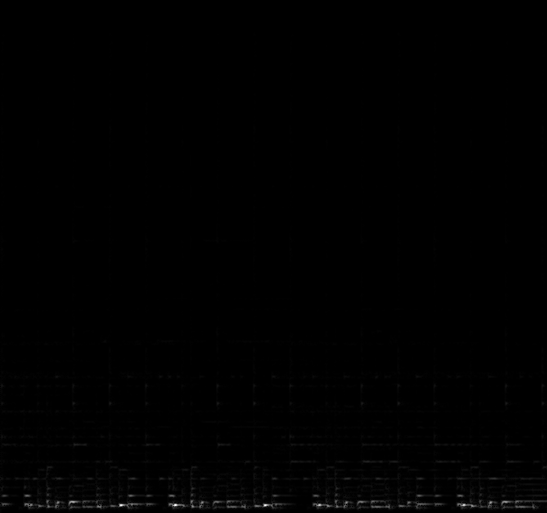

In [5]:
amplitude = np.abs(stft)
imshow(255 * amplitude / amplitude.max())

The amplitude is too dark to see anything. The values are all very small.

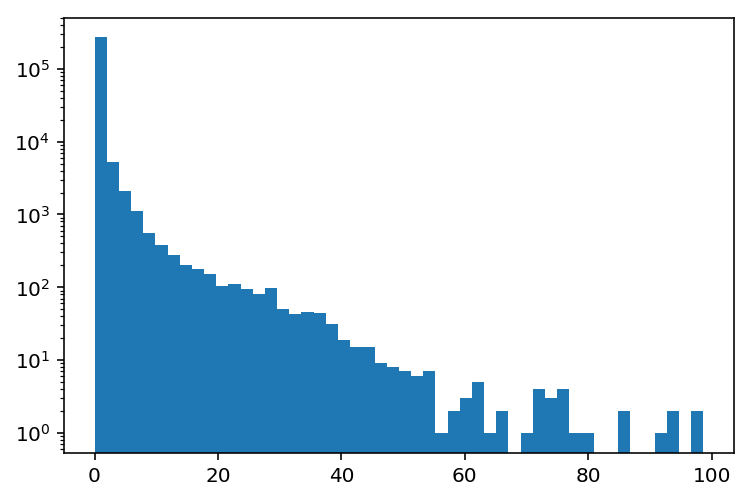

In [6]:
plt.hist(amplitude.flat, bins=50)
plt.yscale('log')
plt.show()

## Power

Another approach is to use power, which is defined as the squared amplitude. We can compute it by squaring the amplitude directly, or by squaring the complex values and taking the magnitude.

In [7]:
print(np.abs(stft[1,1]) ** 2) # square amplitude directly
print(np.abs(stft[1,1] ** 2)) # square complex values then take magnitude

5.857239252006541e-07
5.857239150417138e-07


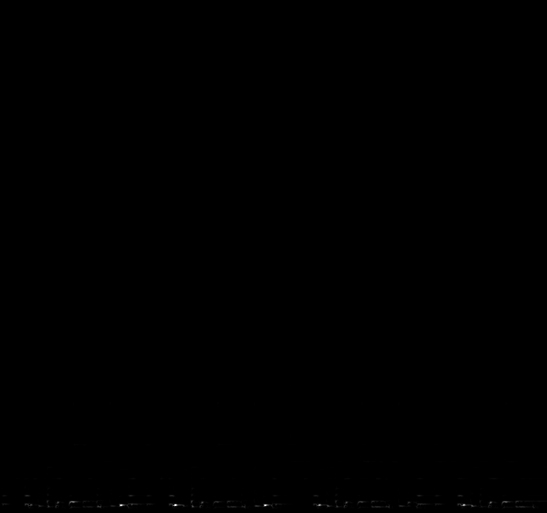

In [8]:
power = np.abs(stft ** 2)
imshow(255 * power / power.max())

Again, most of the values are really small (relative to the max value).

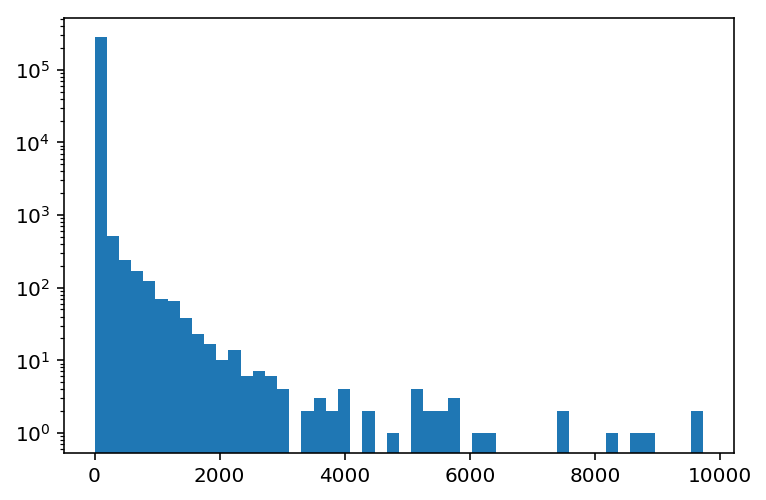

In [9]:
plt.hist(power.flat, bins=50)
plt.yscale('log')
plt.show()

## Decibels (dB)

Let's try decibels. We can compute it from power, or use a helper function `amplitude_to_db` to compute directly from amplitude.

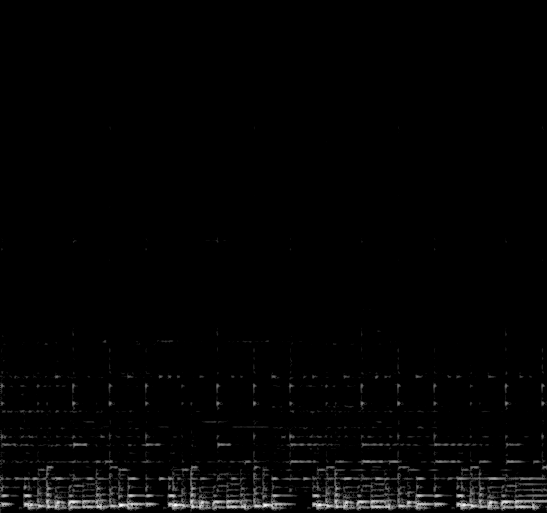

In [10]:
db = librosa.power_to_db(power)
db = librosa.amplitude_to_db(amplitude)
imshow(255 * db / db.max())

This is easier to see. Because the equation for decibels is `10 * log10(power / ref)` the value for `ref` makes a big difference for here. `ref` sets where `0` starts. In linear space, this is just a constant offset.

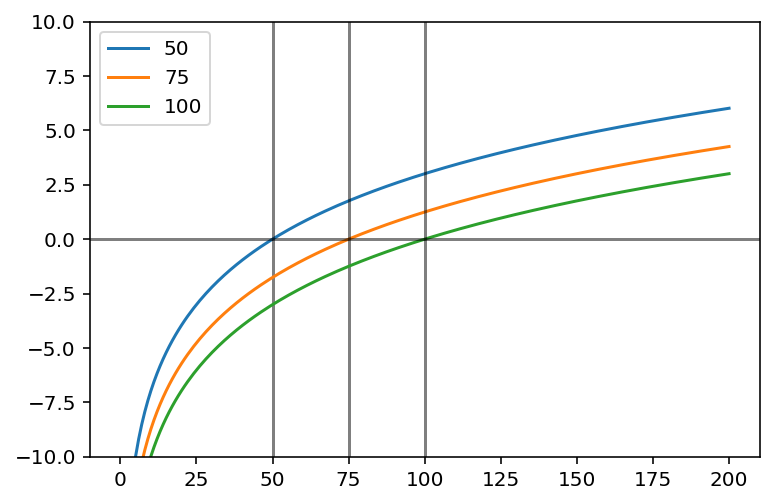

In [11]:
for ref in [50, 75, 100]:
    amplitude_x = np.linspace(0, 200, 200)
    plt.plot(amplitude_x, librosa.core.power_to_db(amplitude_x, ref=ref), label=ref)
    plt.axvline(ref, c='black', alpha=0.5)
plt.ylim(-10, 10)
plt.axhline(0, c='black', alpha=0.5)
plt.legend()
plt.show()

Another way to see this is by plotting the histogram of the output from `amplitude_to_db` with different `ref` values.

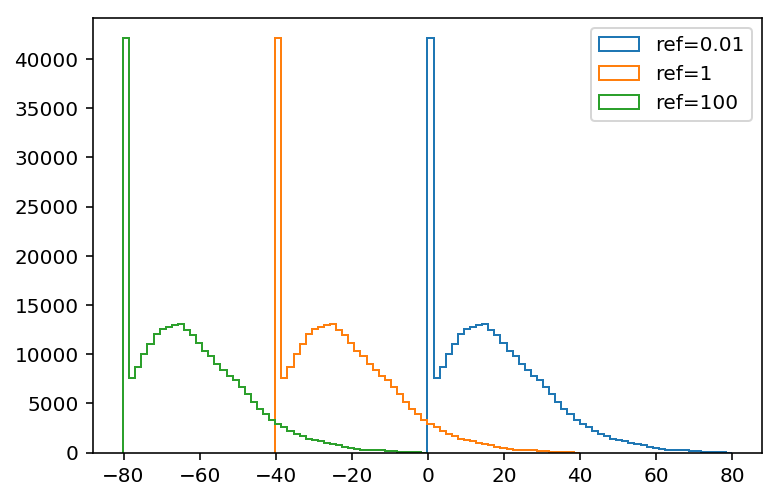

In [12]:
for ref in [0.01, 1, 100]:
    plt.hist(librosa.amplitude_to_db(amplitude, ref=ref).flat,
             bins=50, label=f'ref={ref}', histtype='step')
plt.legend()
plt.show()

This means some data beneath the `ref` decibels is getting cut off and not shown in the image. Let's look at the whole thing:

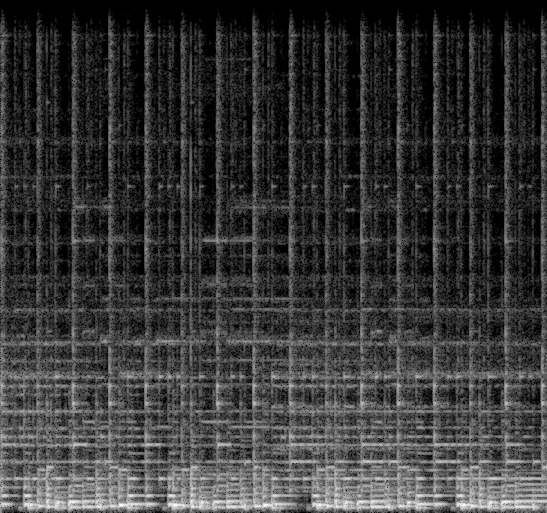

In [13]:
db_norm = np.copy(db)
db_norm -= db_norm.min()
db_norm /= db_norm.max()
imshow(255 * db_norm)

Much noisier, but now we can see everything. Now that we're thinking about `ref` like a cutoff, what does it look like to vary `ref` over time?

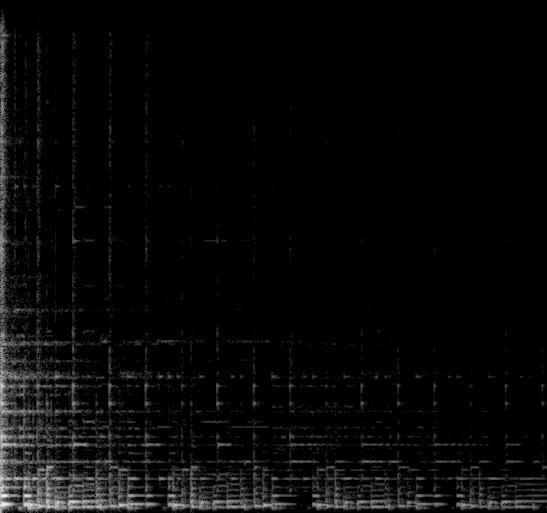

In [14]:
db_varying = []
refs = np.linspace(0.01, 1, amplitude.shape[1])
for i, ref in enumerate(refs):
    cur = librosa.amplitude_to_db(amplitude[:,i], ref=ref)
    db_varying.append(cur)
db_varying = np.asarray(db_varying).T
db_varying /= db_varying.max()
imshow(255 * db_varying)

If we store the `db` as an integer with 256 values, can we still reconstruct a decent spectrogram for varying `ref` values?

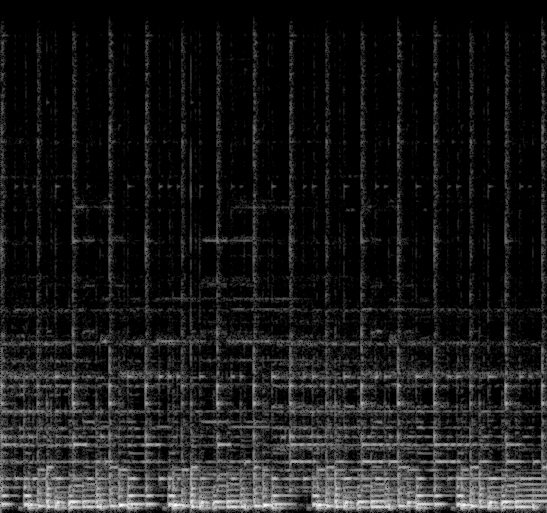

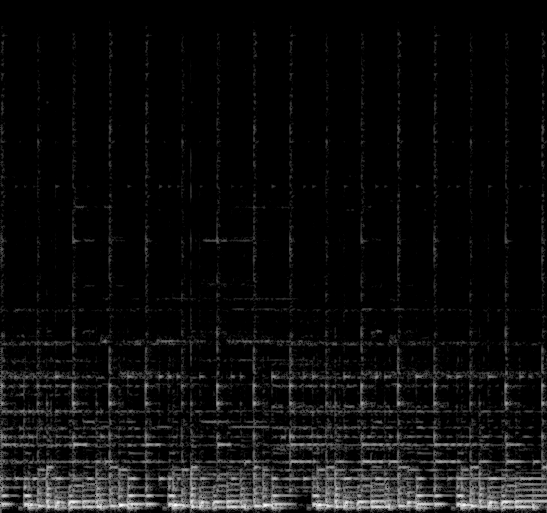

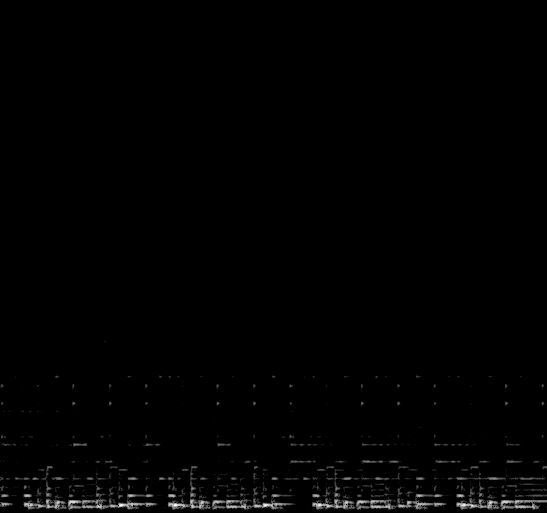

In [15]:
db_256i = (255 * db_norm).astype(np.int32)
for ref_norm in [50, 80, 150]:
    scaling = 255 / (255 - ref_norm)
    result = np.maximum(0, db_256i - ref_norm) * scaling
    imshow(result)

What if we don't want to throw out the noise, we just want to make it darker? Good opportunity to apply a gamma function.

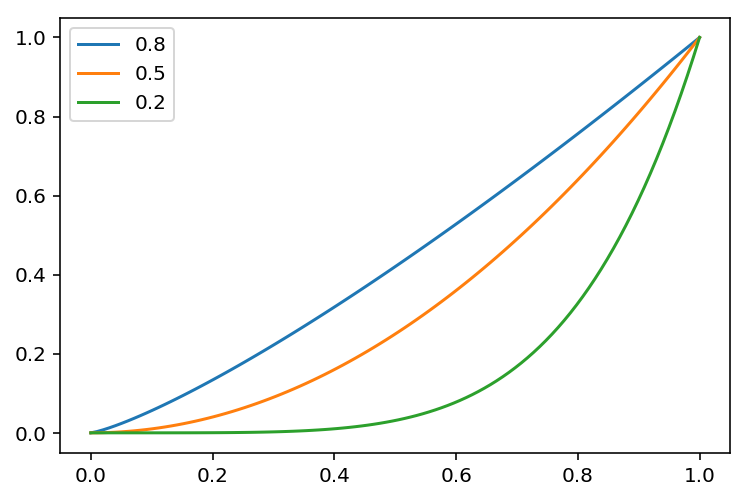

In [16]:
x = np.linspace(0, 1, 100)
for gamma in [0.8, 0.5, 0.2]:
    y = x ** (1/gamma)
    plt.plot(x, y, label=gamma)
plt.legend()
plt.show()

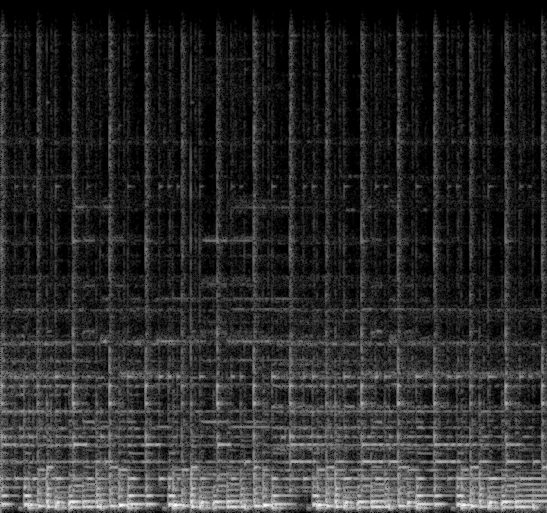

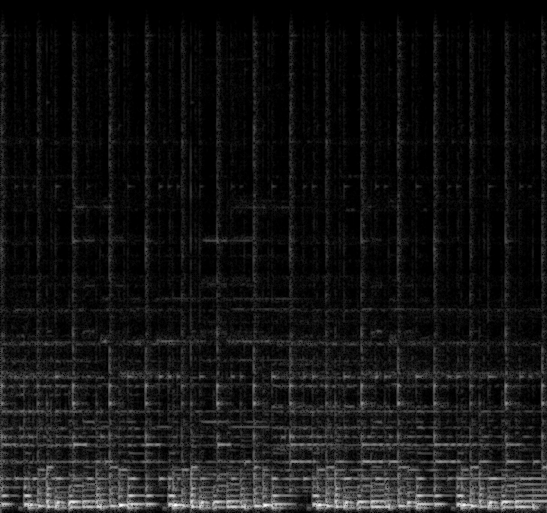

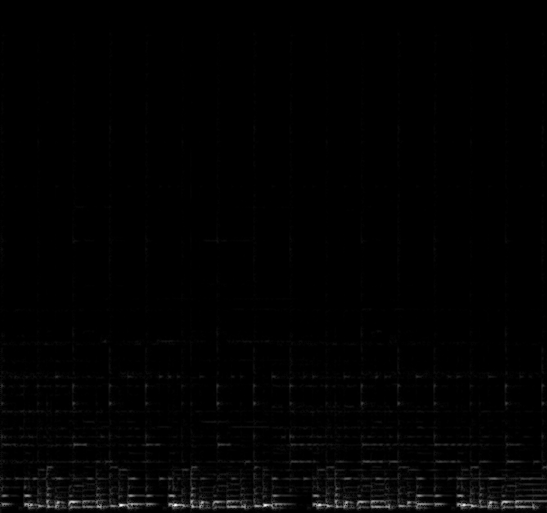

In [17]:
db_256f = db_256i.astype(np.float32)
for gamma in [0.8, 0.5, 0.2]:
    result = (db_256f / 255) ** (1/gamma)
    imshow(255 * result)

Or we could apply a sigmoid.

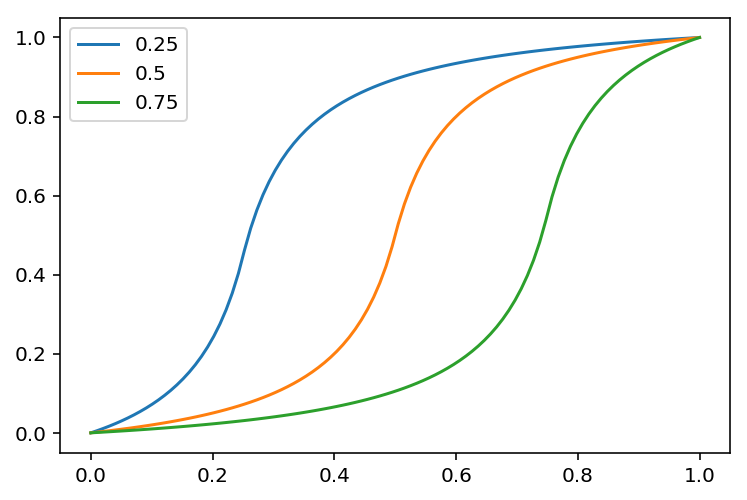

In [18]:
def sigmoid(x, offset, low, high, sharpness):
    remapped = (x - offset) * sharpness
    y = remapped / (1 + np.abs(remapped))
    
    # guarantee the output starts at 0 and ends at 1
    x_high = (high - offset) * sharpness
    x_low = (low - offset) * sharpness
    y_high = x_high / (1 + np.abs(x_high))
    y_low = x_low / (1 + np.abs(x_low))
    y = (y - y_low) / (y_high - y_low)
    
    return y

x = np.linspace(0, 1, 100)
for offset in [0.25, 0.5, 0.75]:
    y = sigmoid(x, offset, 0, 1, 10)
    plt.plot(x, y, label=offset)
plt.legend()
plt.show()

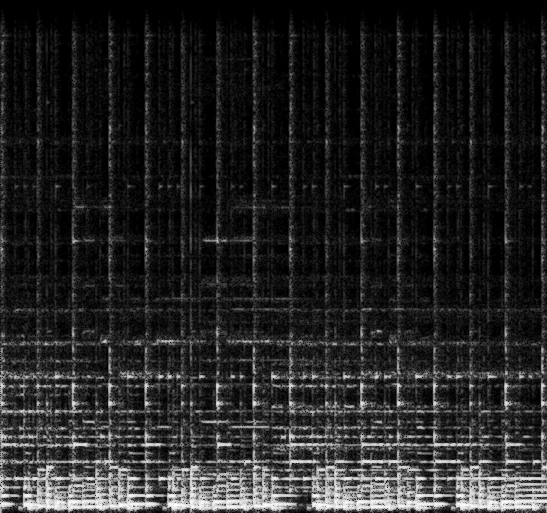

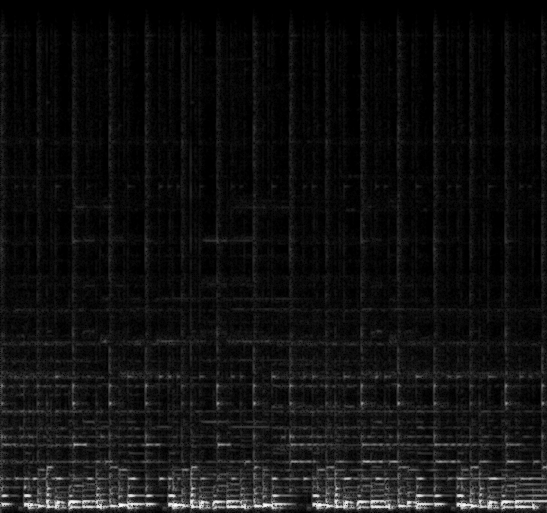

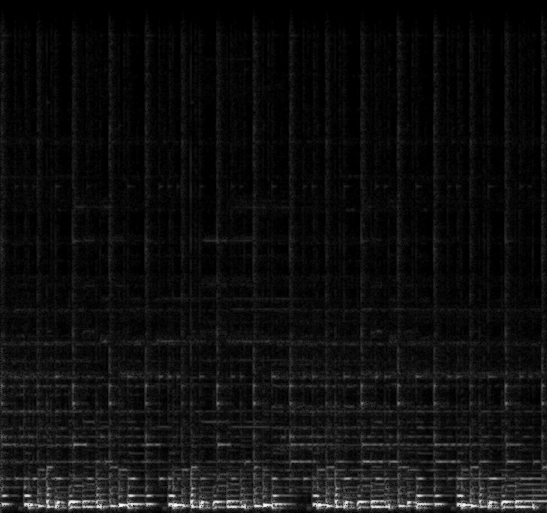

In [19]:
for offset in [0.5, 0.75, 0.8]:
    result = sigmoid(db_256f / 255, offset, 0, 1, 5)
    imshow(255 * result)

Is 256 values enough fidelity to render with color, without running into posterization issues? Below, on the left is the 256-valued version, on the right is the floating point version.

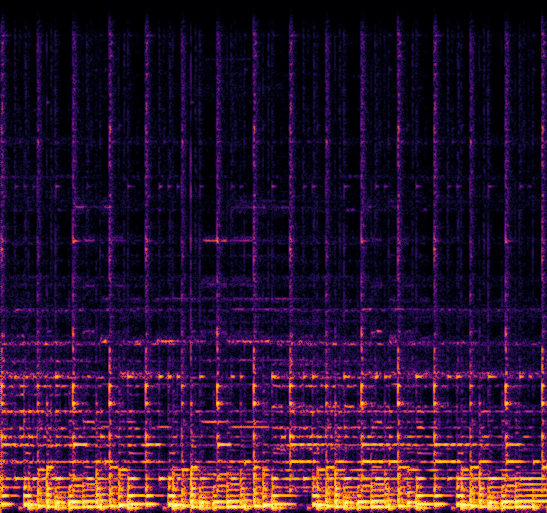

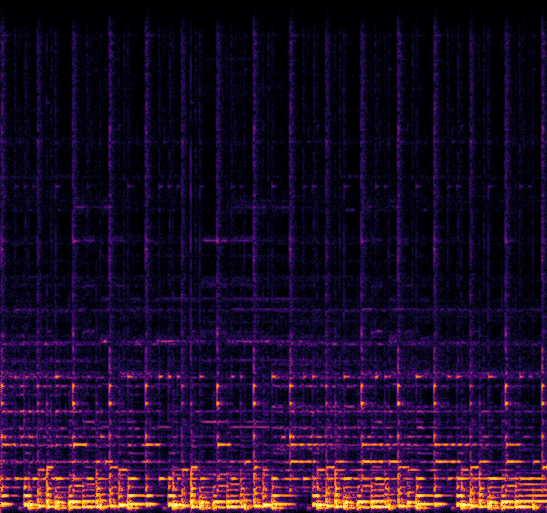

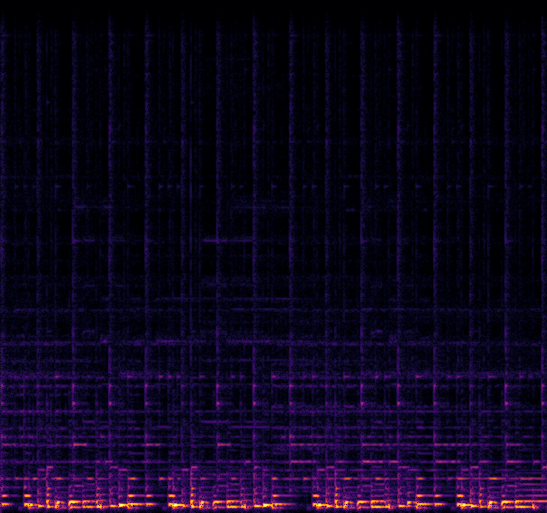

In [20]:
cm = plt.get_cmap('inferno')
for offset in [0.5, 0.6, 0.8]:
    result_l = sigmoid(db_256f / 255, offset, 0, 1, 5)
    result_lc = cm(result_l)[...,:3]
    
    result_r = sigmoid(db_norm, offset, 0, 1, 5)
    result_rc = cm(result_r)[...,:3]
    
    result = np.hstack((
        result_lc[:,:db.shape[1]//2],
        result_rc[:,db.shape[1]//2:]))
    imshow(255 * result)

# CQT

This process is also possible with CQT.

In [21]:
fmin = 20
fmax = 3500
n_bins = 512
octave_range = librosa.core.hz_to_octs(fmax) - librosa.core.hz_to_octs(fmin)
bins_per_octave = int(n_bins / octave_range)
n_bins, bins_per_octave
cqt = librosa.cqt(audio,
                  sr=sr,
                  hop_length=hop_length,
                  fmin=fmin,
                  n_bins=n_bins,
                  bins_per_octave=bins_per_octave,
                  filter_scale=1.0,
                  window='blackmanharris')
cqt = np.flipud(cqt)
cqt.shape, cqt.dtype

((512, 547), dtype('complex128'))

In [22]:
cqt_db = librosa.amplitude_to_db(np.abs(cqt))
cqt_db_norm = np.copy(cqt_db)
cqt_db_norm -= cqt_db_norm.min()
cqt_db_norm /= cqt_db_norm.max()

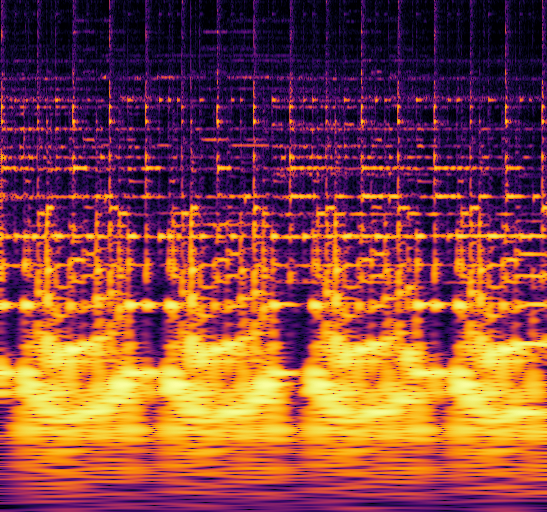

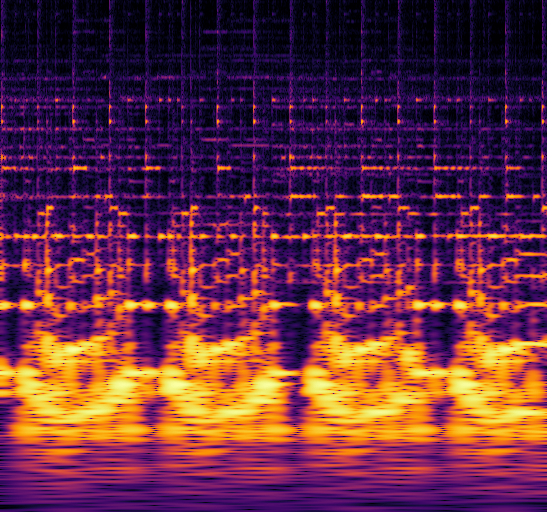

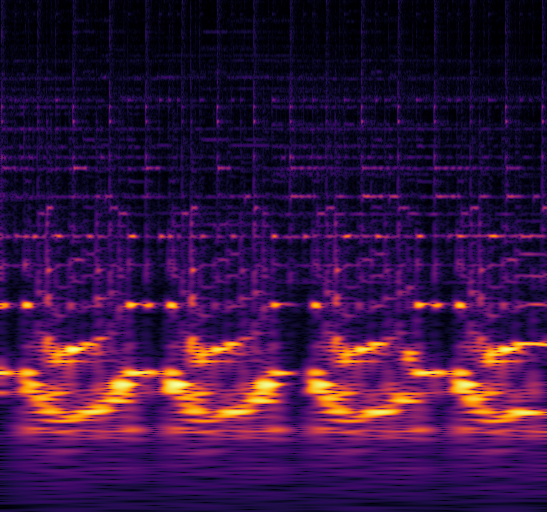

In [23]:
cm = plt.get_cmap('inferno')
for offset in [0.5, 0.6, 0.8]:
    result = sigmoid(cqt_db_norm, offset, 0, 1, 5)
    result_c = cm(result)[...,:3]
    imshow(255 * result_c)

# Mel spectrogram

We can also use Mel spectrograms, which use logarithmically spaced frequency bins. In librosa, the `melspectrogram` function is designed to only output 128 bins.

In [24]:
mel = librosa.feature.melspectrogram(audio, sr, n_fft=1024, hop_length=hop_length)
mel = np.flipud(mel)
mel.shape, mel.shape, mel.dtype

((128, 547), (128, 547), dtype('float64'))

In [25]:
mel_db = librosa.power_to_db(mel)
mel_db_norm = np.copy(mel_db)
mel_db_norm -= mel_db_norm.min()
mel_db_norm /= mel_db_norm.max()

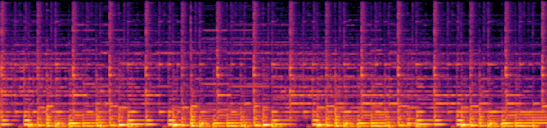

In [26]:
result_c = cm(mel_db_norm)[...,:3]
imshow(255 * result_c)

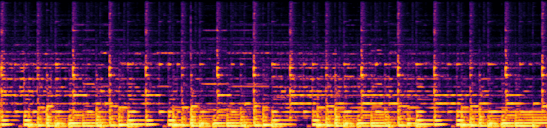

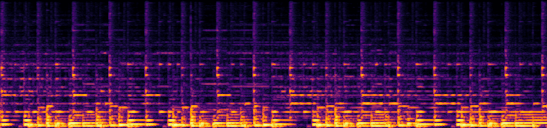

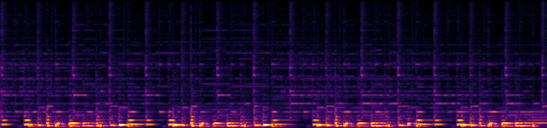

In [27]:
cm = plt.get_cmap('inferno')
for offset in [0.5, 0.6, 0.8]:
    result = sigmoid(mel_db_norm, offset, 0, 1, 5)
    result_c = cm(result)[...,:3]
    imshow(255 * result_c)

# Logarithmic STFT

Finally, we can generate our own logarithmically frequency-scaled representation using remapping. We want to remap with `np.exp`, the inverse of a logarithmic mapping, because OpenCV's `remap()` function maps the destination (output) to the source (input). Now we have a parameter `alpha` that we can tweak to blend between linear and logarithmic.

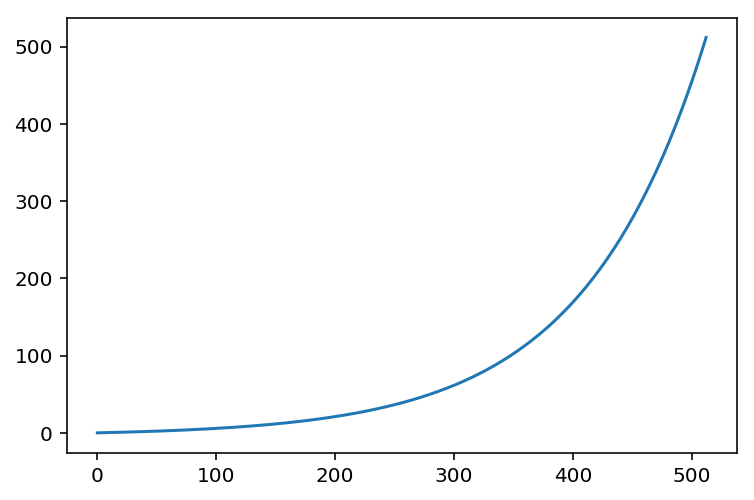

In [28]:
alpha = 5
y_in = np.arange(stft.shape[0])
y_out = y_in / y_in.max()
y_out = np.exp(y_out*alpha)
y_out -= y_out.min()
y_out /= y_out.max()
y_out *= y_in.max()

plt.plot(y_in, y_out)
plt.show()

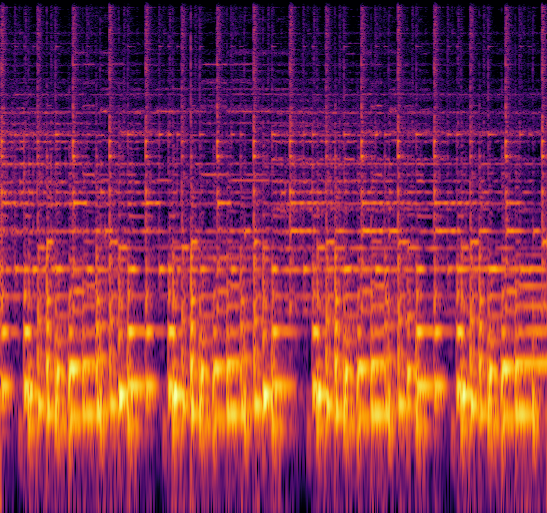

In [29]:
import cv2
mapx = np.arange(stft.shape[1]).reshape(1,-1).repeat(stft.shape[0], axis=0).astype(np.float32)
mapy = y_out.reshape(-1,1).repeat(stft.shape[1], axis=1).astype(np.float32)
db_norm_remapped = cv2.remap(np.flipud(db_norm), mapx, mapy, cv2.INTER_CUBIC)
db_norm_remapped = np.flipud(db_norm_remapped)
result_c = cm(db_norm_remapped)[...,:3]
imshow(255 * result_c)